In [320]:
import numpy as np
import matplotlib.pyplot as plt

In [321]:
# Policy parameterization: Softmax
# State value parameterization: Linear
# State feature vector representation: Fourier (as in HW2)

In [322]:
M = 3 # dimensionality of the fourier transform [2, 10]
# mean_policy_vector = np.ones(2*M+1)*0.05 #some non-zero vector

policy_params = np.ones((2*M+1,2))*0.01
value_params = np.ones(2*M+1)*0.01

softmax_sigma = 0.1
# policy_params = np.zeros((np.power(M+1,2),2))
# value_params = np.zeros(np.power(M+1,2))

policy_step_size = 1e-4 #2e-9
valueFunction_step_size = 3e-5 # fix this to 1e-4, not 1e-5 and not 1e-6.

#Best parameters: policy_step_size = 1e-4, valueFunction_step_size = 3e-5. Gives lowest mean of 128.

gamma = 1

In [323]:
def phi_s_cosine(given_x, given_v, cosineFlag):
    normal_x = normalized_x(given_x, cosineFlag)
    normal_v = normalized_v(given_v, cosineFlag)
    feature_phi = np.zeros(2*M+1)
#     feature_phi = np.zeros(np.power(M+1,2))
    feature_phi[0] = 1
    if cosineFlag:
        for i in range(1, M+1):
            feature_phi[i] = np.cos(i*np.pi*normal_x)
        
        for i in range(1, M+1):
            feature_phi[M+i] = np.cos(i*np.pi*normal_v)

#         for i in range(0,M+1):
#             for j in range(0,M+1):
#                 if i==0 or j==0:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))
#                 else:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))
    
    else:
        for i in range(1, M+1):
            feature_phi[i] = np.sin(i*np.pi*normal_x)
        
        for i in range(1, M+1):
            feature_phi[M+i] = np.sin(i*np.pi*normal_v)

#         for i in range(0,M+1):
#             for j in range(0,M+1):
#                 if i==0 or j==0:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))
#                 else:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))

    return feature_phi

In [324]:
def normalized_x(given_x, cosineFlag):
    if cosineFlag:
        return (given_x+1.2)/(0.5+1.2)
    else:
        return ((given_x+1.2)/(0.5+1.2))*2 - 1
def normalized_v(given_v, cosineFlag):
    if cosineFlag:
        return (given_v+0.7)/(0.7+0.7)
    else:
        return ((given_v+0.7)/(0.7+0.7))*2 - 1

In [325]:
def runEpisode(policy_params,value_params, gamma):
    
    episode_trace = []
    
    total_reward = 0
    x_0 = np.random.uniform(-0.6,-0.4,1)[0]
    begin_state = (x_0,0)
    
    S_t = begin_state
    S_t_plus_1 = begin_state
    for t in range(0, 1000):
        
        state_t_feature_vector = phi_s_cosine(S_t[0], S_t[1], True)
        state_t_feature_policy_param_product = np.dot(policy_params.T, state_t_feature_vector)
        exp_terms = np.exp(softmax_sigma * state_t_feature_policy_param_product)
        pi_values = exp_terms/np.sum(exp_terms)
        
#         A_t = np.random.choice([-1,1], p=list(pi_values))
        
        max_action_idx = np.argmax(pi_values)
        if max_action_idx==1:
            A_t = 1
        else:
            A_t = -1
        
#         threshold = np.dot(state_feature_vector, given_theta)
        
#         print(threshold)
        
#         if threshold<=0:
#             A_t = -1
#         else:
#             A_t = 1
        
        v_t_plus_1 = S_t[1] + 0.001*A_t - 0.0025*np.cos(3*S_t[0])
        x_t_plus_1 = S_t[0] + v_t_plus_1
        
        
        
        if x_t_plus_1 < -1.2:
            x_t_plus_1 = -1.2
            v_t_plus_1 = 0
        elif x_t_plus_1 > 0.5:
            x_t_plus_1 = 0.5
            v_t_plus_1 = 0
        
        if v_t_plus_1 < -0.7:
            v_t_plus_1 = -0.7
        elif v_t_plus_1 > 0.7:
            v_t_plus_1 = 0.7
        
        S_t_plus_1 = (x_t_plus_1, v_t_plus_1)
        
        current_reward = -1
        if x_t_plus_1 == 0.5:
            current_reward = 0
            print("Terminated")
            episode_trace.append((S_t, A_t, 0))
#             break
        else:
            episode_trace.append((S_t, A_t, -1))

            current_reward = -1

            total_reward += -1
#         print("After ",total_reward)
        
    
        v_hat_s = np.dot(state_t_feature_vector, value_params)
        v_hat_s_prime = np.dot(phi_s_cosine(S_t_plus_1[0], S_t_plus_1[1], True),value_params)
        if x_t_plus_1 == 0.5:
            v_hat_s_prime = 0
        
        delta = current_reward + gamma*v_hat_s_prime - v_hat_s
        
        value_params += valueFunction_step_size*delta*state_t_feature_vector
        

        state_t_feature_policy_param_product = np.dot(policy_params.T, state_t_feature_vector)
        
        
        exp_terms = np.exp(softmax_sigma*state_t_feature_policy_param_product)
        pi_values = exp_terms/np.sum(exp_terms)
        
#         print("Pi values: ",pi_values)
#         print("G: ",G,". Delta: ",delta)
        if A_t == -1:
            policy_params[:,0] += policy_step_size*delta*(1-pi_values[0])*state_t_feature_vector
            policy_params[:,1] += policy_step_size*delta*(-pi_values[0])*state_t_feature_vector
        else:
            policy_params[:,0] += policy_step_size*delta*(-pi_values[1])*state_t_feature_vector
            policy_params[:,1] += policy_step_size*delta*(1-pi_values[1])*state_t_feature_vector
    
    
        if x_t_plus_1 == 0.5:
            break

        S_t = S_t_plus_1 #Incrementing time step
    return episode_trace


 EPISODE LENGTH:  1000 CURR ITER:  1
0.0001 3e-05  Max diff:  0.00011248641766839311
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  2
0.0001 3e-05  Max diff:  0.0001686461431629066
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  3
0.0001 3e-05  Max diff:  0.00016905469895378382
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  4
0.0001 3e-05  Max diff:  0.00016795833655220901
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  5
0.0001 3e-05  Max diff:  0.0007217948886628391
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  6
0.0001 3e-05  Max diff:  0.00020660366937377307
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  7
0.0001 3e-05  Max diff:  0.00016841707163453394
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  8
0.0001 3e-05  Max diff:  0.00016781492922571944
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  9
0.0001 3e-05  Max diff:  0.00016852141353902


 EPISODE LENGTH:  1000 CURR ITER:  72
0.0001 3e-05  Max diff:  0.00013098001253043778
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  73
0.0001 3e-05  Max diff:  0.0001630083080572768
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  74
0.0001 3e-05  Max diff:  0.0001297278479308675
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  75
0.0001 3e-05  Max diff:  0.0005648978823943832
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  76
0.0001 3e-05  Max diff:  8.812971105020065e-05
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  77
0.0001 3e-05  Max diff:  8.657442315097158e-05
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  78
0.0001 3e-05  Max diff:  4.1544317384267435e-05
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  79
0.0001 3e-05  Max diff:  7.28282320112926e-05
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  80
0.0001 3e-05  Max diff:  0.0001381134539


 EPISODE LENGTH:  1000 CURR ITER:  144
0.0001 3e-05  Max diff:  0.000166087660357854
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  145
0.0001 3e-05  Max diff:  0.0001608132585137166
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  146
0.0001 3e-05  Max diff:  0.00014262115521011115
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  147
0.0001 3e-05  Max diff:  0.00016766183010162236
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  148
0.0001 3e-05  Max diff:  0.00014617655664758526
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  149
0.0001 3e-05  Max diff:  0.000134619660046768
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  150
0.0001 3e-05  Max diff:  0.00014016116786767265
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  151
0.0001 3e-05  Max diff:  0.00014317415288691952
Mean episode length:  1000.0

 EPISODE LENGTH:  1000 CURR ITER:  152
0.0001 3e-05  Max diff:  0.00

Terminated

 EPISODE LENGTH:  787 CURR ITER:  215
0.0001 3e-05  Max diff:  0.001432387672739106
Mean episode length:  946.82
Terminated

 EPISODE LENGTH:  748 CURR ITER:  216
0.0001 3e-05  Max diff:  0.0014482341082045595
Mean episode length:  944.3

 EPISODE LENGTH:  1000 CURR ITER:  217
0.0001 3e-05  Max diff:  0.0003593127395122731
Mean episode length:  944.3
Terminated

 EPISODE LENGTH:  763 CURR ITER:  218
0.0001 3e-05  Max diff:  0.0004064529325757821
Mean episode length:  941.93

 EPISODE LENGTH:  1000 CURR ITER:  219
0.0001 3e-05  Max diff:  0.00016421096886482314
Mean episode length:  941.93
Terminated

 EPISODE LENGTH:  895 CURR ITER:  220
0.0001 3e-05  Max diff:  0.00020411012278559633
Mean episode length:  940.88
Terminated

 EPISODE LENGTH:  759 CURR ITER:  221
0.0001 3e-05  Max diff:  0.0013116457473114022
Mean episode length:  938.47
Terminated

 EPISODE LENGTH:  849 CURR ITER:  222
0.0001 3e-05  Max diff:  0.0016556414745060276
Mean episode length:  936.96

 EPISODE LEN

 EPISODE LENGTH:  1000 CURR ITER:  282
0.0001 3e-05  Max diff:  0.00016745927144837768
Mean episode length:  808.18

 EPISODE LENGTH:  1000 CURR ITER:  283
0.0001 3e-05  Max diff:  0.00013546676737784605
Mean episode length:  808.18
Terminated

 EPISODE LENGTH:  613 CURR ITER:  284
0.0001 3e-05  Max diff:  0.0003017026197008228
Mean episode length:  807.49

 EPISODE LENGTH:  1000 CURR ITER:  285
0.0001 3e-05  Max diff:  0.00016955598742615478
Mean episode length:  807.49

 EPISODE LENGTH:  1000 CURR ITER:  286
0.0001 3e-05  Max diff:  0.0001523635796868983
Mean episode length:  807.49
Terminated

 EPISODE LENGTH:  499 CURR ITER:  287
0.0001 3e-05  Max diff:  0.00021070892853533064
Mean episode length:  809.28
Terminated

 EPISODE LENGTH:  932 CURR ITER:  288
0.0001 3e-05  Max diff:  0.00171928020819807
Mean episode length:  808.6
Terminated

 EPISODE LENGTH:  602 CURR ITER:  289
0.0001 3e-05  Max diff:  0.0008500582848814213
Mean episode length:  804.62
Terminated

 EPISODE LENGTH:  39


 EPISODE LENGTH:  1000 CURR ITER:  349
0.0001 3e-05  Max diff:  0.00019023026430842194
Mean episode length:  593.72
Terminated

 EPISODE LENGTH:  551 CURR ITER:  350
0.0001 3e-05  Max diff:  0.0006638817593015694
Mean episode length:  589.23
Terminated

 EPISODE LENGTH:  545 CURR ITER:  351
0.0001 3e-05  Max diff:  0.00027324642912730963
Mean episode length:  584.68

 EPISODE LENGTH:  1000 CURR ITER:  352
0.0001 3e-05  Max diff:  0.0001693228968787843
Mean episode length:  590.25

 EPISODE LENGTH:  1000 CURR ITER:  353
0.0001 3e-05  Max diff:  0.0001691514587455513
Mean episode length:  598.53

 EPISODE LENGTH:  1000 CURR ITER:  354
0.0001 3e-05  Max diff:  0.00015572003873210068
Mean episode length:  605.52
Terminated

 EPISODE LENGTH:  846 CURR ITER:  355
0.0001 3e-05  Max diff:  0.00023838020439835746
Mean episode length:  603.98
Terminated

 EPISODE LENGTH:  542 CURR ITER:  356
0.0001 3e-05  Max diff:  0.00022715695369821508
Mean episode length:  599.4

 EPISODE LENGTH:  1000 CURR

Terminated

 EPISODE LENGTH:  979 CURR ITER:  418
0.0001 3e-05  Max diff:  0.0005619146565309097
Mean episode length:  674.67
Terminated

 EPISODE LENGTH:  279 CURR ITER:  419
0.0001 3e-05  Max diff:  0.00030818853159917704
Mean episode length:  674.01
Terminated

 EPISODE LENGTH:  559 CURR ITER:  420
0.0001 3e-05  Max diff:  0.0002472877561203509
Mean episode length:  673.06
Terminated

 EPISODE LENGTH:  458 CURR ITER:  421
0.0001 3e-05  Max diff:  0.0015519826830342146
Mean episode length:  673.63
Terminated

 EPISODE LENGTH:  187 CURR ITER:  422
0.0001 3e-05  Max diff:  0.0005507420670137538
Mean episode length:  672.18
Terminated

 EPISODE LENGTH:  408 CURR ITER:  423
0.0001 3e-05  Max diff:  0.0003329083247656517
Mean episode length:  671.93
Terminated

 EPISODE LENGTH:  857 CURR ITER:  424
0.0001 3e-05  Max diff:  0.00034551526416312997
Mean episode length:  676.48
Terminated

 EPISODE LENGTH:  938 CURR ITER:  425
0.0001 3e-05  Max diff:  0.0003646006520971728
Mean episode length

Terminated

 EPISODE LENGTH:  280 CURR ITER:  487
0.0001 3e-05  Max diff:  0.0003091226487081482
Mean episode length:  590.19
Terminated

 EPISODE LENGTH:  776 CURR ITER:  488
0.0001 3e-05  Max diff:  0.0004782121272468281
Mean episode length:  594.6
Terminated

 EPISODE LENGTH:  484 CURR ITER:  489
0.0001 3e-05  Max diff:  0.0004536064575698835
Mean episode length:  596.11
Terminated

 EPISODE LENGTH:  489 CURR ITER:  490
0.0001 3e-05  Max diff:  0.0003356345517339645
Mean episode length:  597.73

 EPISODE LENGTH:  1000 CURR ITER:  491
0.0001 3e-05  Max diff:  0.0005177549827490146
Mean episode length:  604.49
Terminated

 EPISODE LENGTH:  520 CURR ITER:  492
0.0001 3e-05  Max diff:  0.0006787338725549701
Mean episode length:  605.42
Terminated

 EPISODE LENGTH:  772 CURR ITER:  493
0.0001 3e-05  Max diff:  0.0002452574768676409
Mean episode length:  606.07

 EPISODE LENGTH:  1000 CURR ITER:  494
0.0001 3e-05  Max diff:  0.00034026176986557896
Mean episode length:  606.07
Terminated



Terminated

 EPISODE LENGTH:  189 CURR ITER:  554
0.0001 3e-05  Max diff:  0.000642534276776914
Mean episode length:  596.47
Terminated

 EPISODE LENGTH:  283 CURR ITER:  555
0.0001 3e-05  Max diff:  0.0004981842539338276
Mean episode length:  591.01

 EPISODE LENGTH:  1000 CURR ITER:  556
0.0001 3e-05  Max diff:  0.00032994747865840515
Mean episode length:  592.59
Terminated

 EPISODE LENGTH:  684 CURR ITER:  557
0.0001 3e-05  Max diff:  0.0005482110963800184
Mean episode length:  589.63
Terminated

 EPISODE LENGTH:  271 CURR ITER:  558
0.0001 3e-05  Max diff:  0.0007021301999848972
Mean episode length:  583.27
Terminated

 EPISODE LENGTH:  276 CURR ITER:  559
0.0001 3e-05  Max diff:  0.0005916202576160372
Mean episode length:  576.96
Terminated

 EPISODE LENGTH:  269 CURR ITER:  560
0.0001 3e-05  Max diff:  0.0005118014292122344
Mean episode length:  574.77
Terminated

 EPISODE LENGTH:  280 CURR ITER:  561
0.0001 3e-05  Max diff:  0.000641514109075066
Mean episode length:  571.31

 E

Terminated

 EPISODE LENGTH:  394 CURR ITER:  625
0.0001 3e-05  Max diff:  0.0009613247812399984
Mean episode length:  513.06
Terminated

 EPISODE LENGTH:  140 CURR ITER:  626
0.0001 3e-05  Max diff:  0.000519199819865885
Mean episode length:  511.75
Terminated

 EPISODE LENGTH:  300 CURR ITER:  627
0.0001 3e-05  Max diff:  0.0009790830256934807
Mean episode length:  511.35
Terminated

 EPISODE LENGTH:  905 CURR ITER:  628
0.0001 3e-05  Max diff:  0.0003034220797587979
Mean episode length:  516.18
Terminated

 EPISODE LENGTH:  626 CURR ITER:  629
0.0001 3e-05  Max diff:  0.0007473542315256619
Mean episode length:  512.44
Terminated

 EPISODE LENGTH:  469 CURR ITER:  630
0.0001 3e-05  Max diff:  0.007070172146066929
Mean episode length:  507.13
Terminated

 EPISODE LENGTH:  829 CURR ITER:  631
0.0001 3e-05  Max diff:  0.0008569111341485847
Mean episode length:  505.42
Terminated

 EPISODE LENGTH:  263 CURR ITER:  632
0.0001 3e-05  Max diff:  0.0007411852891636428
Mean episode length:  4


 EPISODE LENGTH:  1000 CURR ITER:  692
0.0001 3e-05  Max diff:  0.0001737428381737736
Mean episode length:  474.48
Terminated

 EPISODE LENGTH:  312 CURR ITER:  693
0.0001 3e-05  Max diff:  0.001000846019325298
Mean episode length:  467.6
Terminated

 EPISODE LENGTH:  151 CURR ITER:  694
0.0001 3e-05  Max diff:  0.001017419276895054
Mean episode length:  463.8

 EPISODE LENGTH:  1000 CURR ITER:  695
0.0001 3e-05  Max diff:  0.00016867605097750996
Mean episode length:  470.9
Terminated

 EPISODE LENGTH:  185 CURR ITER:  696
0.0001 3e-05  Max diff:  0.0007209637738572264
Mean episode length:  470.74

 EPISODE LENGTH:  1000 CURR ITER:  697
0.0001 3e-05  Max diff:  0.00030425463356570023
Mean episode length:  474.74
Terminated

 EPISODE LENGTH:  186 CURR ITER:  698
0.0001 3e-05  Max diff:  0.0008252408730955521
Mean episode length:  475.3
Terminated

 EPISODE LENGTH:  783 CURR ITER:  699
0.0001 3e-05  Max diff:  0.0007012820728139139
Mean episode length:  481.84
Terminated

 EPISODE LENGT


 EPISODE LENGTH:  1000 CURR ITER:  762
0.0001 3e-05  Max diff:  0.0003525534670871973
Mean episode length:  606.63

 EPISODE LENGTH:  1000 CURR ITER:  763
0.0001 3e-05  Max diff:  0.00017121994399256458
Mean episode length:  613.9

 EPISODE LENGTH:  1000 CURR ITER:  764
0.0001 3e-05  Max diff:  0.0001688027388685046
Mean episode length:  613.9

 EPISODE LENGTH:  1000 CURR ITER:  765
0.0001 3e-05  Max diff:  0.00017217908967128955
Mean episode length:  613.9
Terminated

 EPISODE LENGTH:  248 CURR ITER:  766
0.0001 3e-05  Max diff:  0.0006215645802350594
Mean episode length:  606.38
Terminated

 EPISODE LENGTH:  183 CURR ITER:  767
0.0001 3e-05  Max diff:  0.0007502091693216834
Mean episode length:  605.05
Terminated

 EPISODE LENGTH:  184 CURR ITER:  768
0.0001 3e-05  Max diff:  0.0004935998709918524
Mean episode length:  596.89

 EPISODE LENGTH:  1000 CURR ITER:  769
0.0001 3e-05  Max diff:  0.0005392089579499479
Mean episode length:  604.79

 EPISODE LENGTH:  1000 CURR ITER:  770
0.0


 EPISODE LENGTH:  1000 CURR ITER:  832
0.0001 3e-05  Max diff:  0.0009013199723414758
Mean episode length:  634.1

 EPISODE LENGTH:  1000 CURR ITER:  833
0.0001 3e-05  Max diff:  0.00016904459352075699
Mean episode length:  640.99
Terminated

 EPISODE LENGTH:  239 CURR ITER:  834
0.0001 3e-05  Max diff:  0.0008594364480635913
Mean episode length:  633.38
Terminated

 EPISODE LENGTH:  91 CURR ITER:  835
0.0001 3e-05  Max diff:  0.001094919091036331
Mean episode length:  624.29
Terminated

 EPISODE LENGTH:  180 CURR ITER:  836
0.0001 3e-05  Max diff:  0.0012821697717597183
Mean episode length:  622.94
Terminated

 EPISODE LENGTH:  186 CURR ITER:  837
0.0001 3e-05  Max diff:  0.0011413394087096095
Mean episode length:  614.8
Terminated

 EPISODE LENGTH:  186 CURR ITER:  838
0.0001 3e-05  Max diff:  0.0007231028117653977
Mean episode length:  612.34

 EPISODE LENGTH:  1000 CURR ITER:  839
0.0001 3e-05  Max diff:  0.0008432221342727572
Mean episode length:  612.34
Terminated

 EPISODE LENG

Terminated

 EPISODE LENGTH:  137 CURR ITER:  911
0.0001 3e-05  Max diff:  0.0016479173026637609
Mean episode length:  313.88
Terminated

 EPISODE LENGTH:  92 CURR ITER:  912
0.0001 3e-05  Max diff:  0.0010337405345669237
Mean episode length:  313.88
Terminated

 EPISODE LENGTH:  131 CURR ITER:  913
0.0001 3e-05  Max diff:  0.001352712950288125
Mean episode length:  313.32
Terminated

 EPISODE LENGTH:  170 CURR ITER:  914
0.0001 3e-05  Max diff:  0.0008125715768717637
Mean episode length:  313.18
Terminated

 EPISODE LENGTH:  109 CURR ITER:  915
0.0001 3e-05  Max diff:  0.001108540191665161
Mean episode length:  312.42
Terminated

 EPISODE LENGTH:  99 CURR ITER:  916
0.0001 3e-05  Max diff:  0.0007835514267489213
Mean episode length:  303.41
Terminated

 EPISODE LENGTH:  145 CURR ITER:  917
0.0001 3e-05  Max diff:  0.002181357844606699
Mean episode length:  294.86
Terminated

 EPISODE LENGTH:  100 CURR ITER:  918
0.0001 3e-05  Max diff:  0.0008294390696149956
Mean episode length:  285.

Terminated

 EPISODE LENGTH:  190 CURR ITER:  984
0.0001 3e-05  Max diff:  0.0007404247717053003
Mean episode length:  143.34
Terminated

 EPISODE LENGTH:  164 CURR ITER:  985
0.0001 3e-05  Max diff:  0.0009021773151767429
Mean episode length:  143.27
Terminated

 EPISODE LENGTH:  93 CURR ITER:  986
0.0001 3e-05  Max diff:  0.001373449213391626
Mean episode length:  143.24
Terminated

 EPISODE LENGTH:  136 CURR ITER:  987
0.0001 3e-05  Max diff:  0.001613076125120634
Mean episode length:  143.08
Terminated

 EPISODE LENGTH:  99 CURR ITER:  988
0.0001 3e-05  Max diff:  0.0008877863285847581
Mean episode length:  143.13
Terminated

 EPISODE LENGTH:  140 CURR ITER:  989
0.0001 3e-05  Max diff:  0.00178982408783019
Mean episode length:  143.1
Terminated

 EPISODE LENGTH:  217 CURR ITER:  990
0.0001 3e-05  Max diff:  0.002290071651160387
Mean episode length:  143.62
Terminated

 EPISODE LENGTH:  183 CURR ITER:  991
0.0001 3e-05  Max diff:  0.0009596151206286152
Mean episode length:  144.52


Terminated

 EPISODE LENGTH:  176 CURR ITER:  1054
0.0001 3e-05  Max diff:  0.0006857263821860443
Mean episode length:  140.36
Terminated

 EPISODE LENGTH:  97 CURR ITER:  1055
0.0001 3e-05  Max diff:  0.0008757523144513474
Mean episode length:  139.14
Terminated

 EPISODE LENGTH:  143 CURR ITER:  1056
0.0001 3e-05  Max diff:  0.002031513140799329
Mean episode length:  139.57
Terminated

 EPISODE LENGTH:  102 CURR ITER:  1057
0.0001 3e-05  Max diff:  0.000832143712273109
Mean episode length:  139.67
Terminated

 EPISODE LENGTH:  96 CURR ITER:  1058
0.0001 3e-05  Max diff:  0.000788499346011131
Mean episode length:  139.36
Terminated

 EPISODE LENGTH:  142 CURR ITER:  1059
0.0001 3e-05  Max diff:  0.0021041915479401915
Mean episode length:  138.6
Terminated

 EPISODE LENGTH:  196 CURR ITER:  1060
0.0001 3e-05  Max diff:  0.0013448699587074453
Mean episode length:  139.59
Terminated

 EPISODE LENGTH:  194 CURR ITER:  1061
0.0001 3e-05  Max diff:  0.0009106439175288195
Mean episode length

 EPISODE LENGTH:  96 CURR ITER:  1120
0.0001 3e-05  Max diff:  0.0014443460486910295
Mean episode length:  138.19
Terminated

 EPISODE LENGTH:  138 CURR ITER:  1121
0.0001 3e-05  Max diff:  0.0017781986429772773
Mean episode length:  137.85
Terminated

 EPISODE LENGTH:  167 CURR ITER:  1122
0.0001 3e-05  Max diff:  0.0008454542714951205
Mean episode length:  138.21
Terminated

 EPISODE LENGTH:  172 CURR ITER:  1123
0.0001 3e-05  Max diff:  0.0008501590763500058
Mean episode length:  138.95
Terminated

 EPISODE LENGTH:  112 CURR ITER:  1124
0.0001 3e-05  Max diff:  0.0011457368129613593
Mean episode length:  138.7
Terminated

 EPISODE LENGTH:  208 CURR ITER:  1125
0.0001 3e-05  Max diff:  0.0016766177609328359
Mean episode length:  138.88
Terminated

 EPISODE LENGTH:  102 CURR ITER:  1126
0.0001 3e-05  Max diff:  0.0008999414082377401
Mean episode length:  138.94
Terminated

 EPISODE LENGTH:  139 CURR ITER:  1127
0.0001 3e-05  Max diff:  0.0019202745734922533
Mean episode length:  139.0

Terminated

 EPISODE LENGTH:  194 CURR ITER:  1194
0.0001 3e-05  Max diff:  0.0011487126294498357
Mean episode length:  152.67
Terminated

 EPISODE LENGTH:  130 CURR ITER:  1195
0.0001 3e-05  Max diff:  0.0018407556595291946
Mean episode length:  152.91
Terminated

 EPISODE LENGTH:  96 CURR ITER:  1196
0.0001 3e-05  Max diff:  0.001342841709638623
Mean episode length:  152.83
Terminated

 EPISODE LENGTH:  141 CURR ITER:  1197
0.0001 3e-05  Max diff:  0.0019452305264890668
Mean episode length:  152.84
Terminated

 EPISODE LENGTH:  125 CURR ITER:  1198
0.0001 3e-05  Max diff:  0.0011069457214929884
Mean episode length:  152.39
Terminated

 EPISODE LENGTH:  102 CURR ITER:  1199
0.0001 3e-05  Max diff:  0.0007596010952117677
Mean episode length:  151.67
Terminated

 EPISODE LENGTH:  140 CURR ITER:  1200
0.0001 3e-05  Max diff:  0.0015925012064664512
Mean episode length:  151.19
Terminated

 EPISODE LENGTH:  100 CURR ITER:  1201
0.0001 3e-05  Max diff:  0.0008628614968988757
Mean episode le

Terminated

 EPISODE LENGTH:  198 CURR ITER:  1260
0.0001 3e-05  Max diff:  0.0011573526064203032
Mean episode length:  148.95
Terminated

 EPISODE LENGTH:  97 CURR ITER:  1261
0.0001 3e-05  Max diff:  0.0016244932641915552
Mean episode length:  147.93
Terminated

 EPISODE LENGTH:  143 CURR ITER:  1262
0.0001 3e-05  Max diff:  0.0021617829877862427
Mean episode length:  147.96
Terminated

 EPISODE LENGTH:  145 CURR ITER:  1263
0.0001 3e-05  Max diff:  0.001988599778923364
Mean episode length:  147.56
Terminated

 EPISODE LENGTH:  181 CURR ITER:  1264
0.0001 3e-05  Max diff:  0.000979254732105611
Mean episode length:  147.19
Terminated

 EPISODE LENGTH:  241 CURR ITER:  1265
0.0001 3e-05  Max diff:  0.003183218529026588
Mean episode length:  147.27
Terminated

 EPISODE LENGTH:  97 CURR ITER:  1266
0.0001 3e-05  Max diff:  0.0017373084121388577
Mean episode length:  147.2
Terminated

 EPISODE LENGTH:  136 CURR ITER:  1267
0.0001 3e-05  Max diff:  0.0018029870618543886
Mean episode length

Terminated

 EPISODE LENGTH:  102 CURR ITER:  1330
0.0001 3e-05  Max diff:  0.0009721276756473052
Mean episode length:  146.89
Terminated

 EPISODE LENGTH:  139 CURR ITER:  1331
0.0001 3e-05  Max diff:  0.001838923781771723
Mean episode length:  146.28
Terminated

 EPISODE LENGTH:  171 CURR ITER:  1332
0.0001 3e-05  Max diff:  0.0009966328406362662
Mean episode length:  146.09
Terminated

 EPISODE LENGTH:  177 CURR ITER:  1333
0.0001 3e-05  Max diff:  0.00106573434708844
Mean episode length:  145.58
Terminated

 EPISODE LENGTH:  177 CURR ITER:  1334
0.0001 3e-05  Max diff:  0.000790049358785197
Mean episode length:  145.43
Terminated

 EPISODE LENGTH:  140 CURR ITER:  1335
0.0001 3e-05  Max diff:  0.001726817942676373
Mean episode length:  144.9
Terminated

 EPISODE LENGTH:  205 CURR ITER:  1336
0.0001 3e-05  Max diff:  0.0017588629068092387
Mean episode length:  145.89
Terminated

 EPISODE LENGTH:  97 CURR ITER:  1337
0.0001 3e-05  Max diff:  0.0015175487435874768
Mean episode length:

Terminated

 EPISODE LENGTH:  140 CURR ITER:  1399
0.0001 3e-05  Max diff:  0.0019926288628372424
Mean episode length:  140.34
Terminated

 EPISODE LENGTH:  101 CURR ITER:  1400
0.0001 3e-05  Max diff:  0.0007721342485351862
Mean episode length:  139.63
Terminated

 EPISODE LENGTH:  134 CURR ITER:  1401
0.0001 3e-05  Max diff:  0.001638940176055259
Mean episode length:  139.55
Terminated

 EPISODE LENGTH:  92 CURR ITER:  1402
0.0001 3e-05  Max diff:  0.0013040166358049901
Mean episode length:  138.4
Terminated

 EPISODE LENGTH:  138 CURR ITER:  1403
0.0001 3e-05  Max diff:  0.001798504091169606
Mean episode length:  138.04
Terminated

 EPISODE LENGTH:  107 CURR ITER:  1404
0.0001 3e-05  Max diff:  0.0009831963854755044
Mean episode length:  137.37
Terminated

 EPISODE LENGTH:  128 CURR ITER:  1405
0.0001 3e-05  Max diff:  0.0013342591347797195
Mean episode length:  136.93
Terminated

 EPISODE LENGTH:  171 CURR ITER:  1406
0.0001 3e-05  Max diff:  0.0009794074299527694
Mean episode leng

Terminated

 EPISODE LENGTH:  144 CURR ITER:  1468
0.0001 3e-05  Max diff:  0.002082888135489791
Mean episode length:  138.39
Terminated

 EPISODE LENGTH:  175 CURR ITER:  1469
0.0001 3e-05  Max diff:  0.0010495066260701458
Mean episode length:  138.28
Terminated

 EPISODE LENGTH:  183 CURR ITER:  1470
0.0001 3e-05  Max diff:  0.0008797383908712292
Mean episode length:  139.0
Terminated

 EPISODE LENGTH:  165 CURR ITER:  1471
0.0001 3e-05  Max diff:  0.0009887705553848491
Mean episode length:  139.23
Terminated

 EPISODE LENGTH:  177 CURR ITER:  1472
0.0001 3e-05  Max diff:  0.0009151696284447064
Mean episode length:  139.55
Terminated

 EPISODE LENGTH:  94 CURR ITER:  1473
0.0001 3e-05  Max diff:  0.0015367515321432074
Mean episode length:  139.55
Terminated

 EPISODE LENGTH:  141 CURR ITER:  1474
0.0001 3e-05  Max diff:  0.0020694340493752905
Mean episode length:  139.57
Terminated

 EPISODE LENGTH:  95 CURR ITER:  1475
0.0001 3e-05  Max diff:  0.0010933478417284592
Mean episode leng

Terminated

 EPISODE LENGTH:  203 CURR ITER:  1540
0.0001 3e-05  Max diff:  0.0013525940193838404
Mean episode length:  138.75
Terminated

 EPISODE LENGTH:  203 CURR ITER:  1541
0.0001 3e-05  Max diff:  0.0013762684600589215
Mean episode length:  139.36
Terminated

 EPISODE LENGTH:  99 CURR ITER:  1542
0.0001 3e-05  Max diff:  0.0014179013577733518
Mean episode length:  139.4
Terminated

 EPISODE LENGTH:  142 CURR ITER:  1543
0.0001 3e-05  Max diff:  0.0021754726660091483
Mean episode length:  139.39
Terminated

 EPISODE LENGTH:  96 CURR ITER:  1544
0.0001 3e-05  Max diff:  0.0013176780524099818
Mean episode length:  139.09
Terminated

 EPISODE LENGTH:  145 CURR ITER:  1545
0.0001 3e-05  Max diff:  0.0023278963406707653
Mean episode length:  138.56
Terminated

 EPISODE LENGTH:  186 CURR ITER:  1546
0.0001 3e-05  Max diff:  0.0008704228050067792
Mean episode length:  138.65
Terminated

 EPISODE LENGTH:  146 CURR ITER:  1547
0.0001 3e-05  Max diff:  0.002331562847967067
Mean episode leng

Terminated

 EPISODE LENGTH:  167 CURR ITER:  1617
0.0001 3e-05  Max diff:  0.0008777399641589079
Mean episode length:  141.89
Terminated

 EPISODE LENGTH:  97 CURR ITER:  1618
0.0001 3e-05  Max diff:  0.0009877380571988448
Mean episode length:  141.43
Terminated

 EPISODE LENGTH:  143 CURR ITER:  1619
0.0001 3e-05  Max diff:  0.0019740067559951002
Mean episode length:  141.55
Terminated

 EPISODE LENGTH:  141 CURR ITER:  1620
0.0001 3e-05  Max diff:  0.0018114836533036638
Mean episode length:  141.5
Terminated

 EPISODE LENGTH:  173 CURR ITER:  1621
0.0001 3e-05  Max diff:  0.0010345247441960886
Mean episode length:  142.06
Terminated

 EPISODE LENGTH:  94 CURR ITER:  1622
0.0001 3e-05  Max diff:  0.0012854752323075425
Mean episode length:  140.88
Terminated

 EPISODE LENGTH:  144 CURR ITER:  1623
0.0001 3e-05  Max diff:  0.00201966463237363
Mean episode length:  140.25
Terminated

 EPISODE LENGTH:  92 CURR ITER:  1624
0.0001 3e-05  Max diff:  0.0014798432514546572
Mean episode length

Terminated

 EPISODE LENGTH:  138 CURR ITER:  1688
0.0001 3e-05  Max diff:  0.0019907331587150634
Mean episode length:  138.37
Terminated

 EPISODE LENGTH:  143 CURR ITER:  1689
0.0001 3e-05  Max diff:  0.002099043144850765
Mean episode length:  138.0
Terminated

 EPISODE LENGTH:  99 CURR ITER:  1690
0.0001 3e-05  Max diff:  0.0007612876197517215
Mean episode length:  137.29
Terminated

 EPISODE LENGTH:  144 CURR ITER:  1691
0.0001 3e-05  Max diff:  0.0020009898313281815
Mean episode length:  136.92
Terminated

 EPISODE LENGTH:  199 CURR ITER:  1692
0.0001 3e-05  Max diff:  0.0017362686524149407
Mean episode length:  137.93
Terminated

 EPISODE LENGTH:  169 CURR ITER:  1693
0.0001 3e-05  Max diff:  0.0011208694352884685
Mean episode length:  138.64
Terminated

 EPISODE LENGTH:  166 CURR ITER:  1694
0.0001 3e-05  Max diff:  0.0010610743476372198
Mean episode length:  138.84
Terminated

 EPISODE LENGTH:  171 CURR ITER:  1695
0.0001 3e-05  Max diff:  0.0011403491579996539
Mean episode len

Terminated

 EPISODE LENGTH:  221 CURR ITER:  1764
0.0001 3e-05  Max diff:  0.002278686540514968
Mean episode length:  140.61
Terminated

 EPISODE LENGTH:  190 CURR ITER:  1765
0.0001 3e-05  Max diff:  0.0008623772963222143
Mean episode length:  140.36
Terminated

 EPISODE LENGTH:  181 CURR ITER:  1766
0.0001 3e-05  Max diff:  0.0010549870683095597
Mean episode length:  140.49
Terminated

 EPISODE LENGTH:  102 CURR ITER:  1767
0.0001 3e-05  Max diff:  0.0011390937948050767
Mean episode length:  140.27
Terminated

 EPISODE LENGTH:  198 CURR ITER:  1768
0.0001 3e-05  Max diff:  0.0010654008433032547
Mean episode length:  140.36
Terminated

 EPISODE LENGTH:  145 CURR ITER:  1769
0.0001 3e-05  Max diff:  0.0023101030237822895
Mean episode length:  140.34
Terminated

 EPISODE LENGTH:  147 CURR ITER:  1770
0.0001 3e-05  Max diff:  0.0023970915416457184
Mean episode length:  139.6
Terminated

 EPISODE LENGTH:  179 CURR ITER:  1771
0.0001 3e-05  Max diff:  0.001115868568602435
Mean episode len

Terminated

 EPISODE LENGTH:  141 CURR ITER:  1830
0.0001 3e-05  Max diff:  0.0022011170651139167
Mean episode length:  142.14
Terminated

 EPISODE LENGTH:  142 CURR ITER:  1831
0.0001 3e-05  Max diff:  0.002264155719165828
Mean episode length:  141.78
Terminated

 EPISODE LENGTH:  143 CURR ITER:  1832
0.0001 3e-05  Max diff:  0.0021453326387408933
Mean episode length:  142.26
Terminated

 EPISODE LENGTH:  234 CURR ITER:  1833
0.0001 3e-05  Max diff:  0.0029816937975696844
Mean episode length:  143.17
Terminated

 EPISODE LENGTH:  180 CURR ITER:  1834
0.0001 3e-05  Max diff:  0.0012362028474744158
Mean episode length:  143.16
Terminated

 EPISODE LENGTH:  178 CURR ITER:  1835
0.0001 3e-05  Max diff:  0.001250543246146596
Mean episode length:  143.51
Terminated

 EPISODE LENGTH:  188 CURR ITER:  1836
0.0001 3e-05  Max diff:  0.0007936832465652854
Mean episode length:  144.47
Terminated

 EPISODE LENGTH:  94 CURR ITER:  1837
0.0001 3e-05  Max diff:  0.0016942168179587547
Mean episode len

Terminated

 EPISODE LENGTH:  141 CURR ITER:  1900
0.0001 3e-05  Max diff:  0.0022173570555052424
Mean episode length:  138.06
Terminated

 EPISODE LENGTH:  146 CURR ITER:  1901
0.0001 3e-05  Max diff:  0.0023493951425949677
Mean episode length:  138.07
Terminated

 EPISODE LENGTH:  143 CURR ITER:  1902
0.0001 3e-05  Max diff:  0.0021808612087341195
Mean episode length:  138.15
Terminated

 EPISODE LENGTH:  181 CURR ITER:  1903
0.0001 3e-05  Max diff:  0.0009383407801858978
Mean episode length:  138.79
Terminated

 EPISODE LENGTH:  121 CURR ITER:  1904
0.0001 3e-05  Max diff:  0.001539468057955018
Mean episode length:  139.02
Terminated

 EPISODE LENGTH:  95 CURR ITER:  1905
0.0001 3e-05  Max diff:  0.0013688464863275962
Mean episode length:  138.68
Terminated

 EPISODE LENGTH:  146 CURR ITER:  1906
0.0001 3e-05  Max diff:  0.002370722368141953
Mean episode length:  138.86
Terminated

 EPISODE LENGTH:  145 CURR ITER:  1907
0.0001 3e-05  Max diff:  0.0022984063802074517
Mean episode len

Terminated

 EPISODE LENGTH:  97 CURR ITER:  1972
0.0001 3e-05  Max diff:  0.0011208346949823367
Mean episode length:  135.1
Terminated

 EPISODE LENGTH:  144 CURR ITER:  1973
0.0001 3e-05  Max diff:  0.0023015685900167338
Mean episode length:  135.58
Terminated

 EPISODE LENGTH:  102 CURR ITER:  1974
0.0001 3e-05  Max diff:  0.000823144175029572
Mean episode length:  135.66
Terminated

 EPISODE LENGTH:  92 CURR ITER:  1975
0.0001 3e-05  Max diff:  0.0015260132309005414
Mean episode length:  134.7
Terminated

 EPISODE LENGTH:  140 CURR ITER:  1976
0.0001 3e-05  Max diff:  0.0020951914332170696
Mean episode length:  134.15
Terminated

 EPISODE LENGTH:  98 CURR ITER:  1977
0.0001 3e-05  Max diff:  0.0009794938925136165
Mean episode length:  133.27
Terminated

 EPISODE LENGTH:  96 CURR ITER:  1978
0.0001 3e-05  Max diff:  0.00105063490074217
Mean episode length:  132.77
Terminated

 EPISODE LENGTH:  140 CURR ITER:  1979
0.0001 3e-05  Max diff:  0.0021893866023935393
Mean episode length:  

Terminated

 EPISODE LENGTH:  184 CURR ITER:  2048
0.0001 3e-05  Max diff:  0.0009910533582095093
Mean episode length:  134.76
Terminated

 EPISODE LENGTH:  180 CURR ITER:  2049
0.0001 3e-05  Max diff:  0.0012003033644111816
Mean episode length:  134.94
Terminated

 EPISODE LENGTH:  93 CURR ITER:  2050
0.0001 3e-05  Max diff:  0.0017003668267021599
Mean episode length:  133.94
Terminated

 EPISODE LENGTH:  99 CURR ITER:  2051
0.0001 3e-05  Max diff:  0.0012069929540626523
Mean episode length:  133.15
Terminated

 EPISODE LENGTH:  127 CURR ITER:  2052
0.0001 3e-05  Max diff:  0.0018743997744605778
Mean episode length:  132.44
Terminated

 EPISODE LENGTH:  146 CURR ITER:  2053
0.0001 3e-05  Max diff:  0.002418019439219765
Mean episode length:  132.95
Terminated

 EPISODE LENGTH:  122 CURR ITER:  2054
0.0001 3e-05  Max diff:  0.0015792710936267107
Mean episode length:  133.14
Terminated

 EPISODE LENGTH:  146 CURR ITER:  2055
0.0001 3e-05  Max diff:  0.0024775793185238815
Mean episode len

Terminated

 EPISODE LENGTH:  140 CURR ITER:  2118
0.0001 3e-05  Max diff:  0.0021765098977540864
Mean episode length:  135.48
Terminated

 EPISODE LENGTH:  92 CURR ITER:  2119
0.0001 3e-05  Max diff:  0.0013831274723502818
Mean episode length:  134.73
Terminated

 EPISODE LENGTH:  141 CURR ITER:  2120
0.0001 3e-05  Max diff:  0.0023111542654120076
Mean episode length:  135.22
Terminated

 EPISODE LENGTH:  97 CURR ITER:  2121
0.0001 3e-05  Max diff:  0.0009553748691766006
Mean episode length:  135.2
Terminated

 EPISODE LENGTH:  95 CURR ITER:  2122
0.0001 3e-05  Max diff:  0.0011272003817767717
Mean episode length:  134.72
Terminated

 EPISODE LENGTH:  141 CURR ITER:  2123
0.0001 3e-05  Max diff:  0.0022826180638396143
Mean episode length:  135.13
Terminated

 EPISODE LENGTH:  95 CURR ITER:  2124
0.0001 3e-05  Max diff:  0.0011385256697311608
Mean episode length:  135.06
Terminated

 EPISODE LENGTH:  141 CURR ITER:  2125
0.0001 3e-05  Max diff:  0.0022809259773738377
Mean episode lengt

Terminated

 EPISODE LENGTH:  147 CURR ITER:  2190
0.0001 3e-05  Max diff:  0.0025693337596584542
Mean episode length:  132.47
Terminated

 EPISODE LENGTH:  95 CURR ITER:  2191
0.0001 3e-05  Max diff:  0.0012768811440241057
Mean episode length:  132.0
Terminated

 EPISODE LENGTH:  92 CURR ITER:  2192
0.0001 3e-05  Max diff:  0.0017457344545105946
Mean episode length:  131.5
Terminated

 EPISODE LENGTH:  143 CURR ITER:  2193
0.0001 3e-05  Max diff:  0.0022945703417955876
Mean episode length:  131.16
Terminated

 EPISODE LENGTH:  117 CURR ITER:  2194
0.0001 3e-05  Max diff:  0.0014862622371866197
Mean episode length:  131.27
Terminated

 EPISODE LENGTH:  144 CURR ITER:  2195
0.0001 3e-05  Max diff:  0.0024167600083037644
Mean episode length:  131.27
Terminated

 EPISODE LENGTH:  144 CURR ITER:  2196
0.0001 3e-05  Max diff:  0.002305352221106005
Mean episode length:  131.69
Terminated

 EPISODE LENGTH:  166 CURR ITER:  2197
0.0001 3e-05  Max diff:  0.0011020619492939088
Mean episode lengt

Terminated

 EPISODE LENGTH:  144 CURR ITER:  2256
0.0001 3e-05  Max diff:  0.002235208440986347
Mean episode length:  136.13
Terminated

 EPISODE LENGTH:  194 CURR ITER:  2257
0.0001 3e-05  Max diff:  0.001504295935993466
Mean episode length:  136.61
Terminated

 EPISODE LENGTH:  143 CURR ITER:  2258
0.0001 3e-05  Max diff:  0.002268467780997707
Mean episode length:  136.95
Terminated

 EPISODE LENGTH:  101 CURR ITER:  2259
0.0001 3e-05  Max diff:  0.00085720062367034
Mean episode length:  137.04
Terminated

 EPISODE LENGTH:  93 CURR ITER:  2260
0.0001 3e-05  Max diff:  0.001444702112241042
Mean episode length:  136.51
Terminated

 EPISODE LENGTH:  94 CURR ITER:  2261
0.0001 3e-05  Max diff:  0.0012269192752466518
Mean episode length:  136.0
Terminated

 EPISODE LENGTH:  98 CURR ITER:  2262
0.0001 3e-05  Max diff:  0.0009475556226995474
Mean episode length:  136.05
Terminated

 EPISODE LENGTH:  143 CURR ITER:  2263
0.0001 3e-05  Max diff:  0.0024642366845101793
Mean episode length:  1

Terminated

 EPISODE LENGTH:  143 CURR ITER:  2324
0.0001 3e-05  Max diff:  0.00246832507147432
Mean episode length:  137.51
Terminated

 EPISODE LENGTH:  144 CURR ITER:  2325
0.0001 3e-05  Max diff:  0.0024472606437067057
Mean episode length:  137.85
Terminated

 EPISODE LENGTH:  94 CURR ITER:  2326
0.0001 3e-05  Max diff:  0.0017020198990259083
Mean episode length:  137.87
Terminated

 EPISODE LENGTH:  144 CURR ITER:  2327
0.0001 3e-05  Max diff:  0.002478301725362786
Mean episode length:  138.39
Terminated

 EPISODE LENGTH:  141 CURR ITER:  2328
0.0001 3e-05  Max diff:  0.0021444246105442044
Mean episode length:  138.37
Terminated

 EPISODE LENGTH:  108 CURR ITER:  2329
0.0001 3e-05  Max diff:  0.0010249304683839777
Mean episode length:  137.58
Terminated

 EPISODE LENGTH:  146 CURR ITER:  2330
0.0001 3e-05  Max diff:  0.002477213761974295
Mean episode length:  137.61
Terminated

 EPISODE LENGTH:  101 CURR ITER:  2331
0.0001 3e-05  Max diff:  0.0008609685798384725
Mean episode lengt

Terminated

 EPISODE LENGTH:  169 CURR ITER:  2397
0.0001 3e-05  Max diff:  0.0012449758728641513
Mean episode length:  135.56
Terminated

 EPISODE LENGTH:  164 CURR ITER:  2398
0.0001 3e-05  Max diff:  0.0011781608532352994
Mean episode length:  135.73
Terminated

 EPISODE LENGTH:  188 CURR ITER:  2399
0.0001 3e-05  Max diff:  0.0011264708717555472
Mean episode length:  135.88
Terminated

 EPISODE LENGTH:  162 CURR ITER:  2400
0.0001 3e-05  Max diff:  0.001214532366241916
Mean episode length:  136.06
Terminated

 EPISODE LENGTH:  164 CURR ITER:  2401
0.0001 3e-05  Max diff:  0.0011811993429176049
Mean episode length:  136.28
Terminated

 EPISODE LENGTH:  146 CURR ITER:  2402
0.0001 3e-05  Max diff:  0.002530157736992167
Mean episode length:  136.29
Terminated

 EPISODE LENGTH:  195 CURR ITER:  2403
0.0001 3e-05  Max diff:  0.001518736738519877
Mean episode length:  136.46
Terminated

 EPISODE LENGTH:  103 CURR ITER:  2404
0.0001 3e-05  Max diff:  0.0009024949476982291
Mean episode len

Terminated

 EPISODE LENGTH:  166 CURR ITER:  2471
0.0001 3e-05  Max diff:  0.0012593779761804202
Mean episode length:  131.98
Terminated

 EPISODE LENGTH:  163 CURR ITER:  2472
0.0001 3e-05  Max diff:  0.0014371131887469524
Mean episode length:  131.97
Terminated

 EPISODE LENGTH:  195 CURR ITER:  2473
0.0001 3e-05  Max diff:  0.0016271980668873254
Mean episode length:  132.47
Terminated

 EPISODE LENGTH:  147 CURR ITER:  2474
0.0001 3e-05  Max diff:  0.0025821324283867853
Mean episode length:  132.0
Terminated

 EPISODE LENGTH:  162 CURR ITER:  2475
0.0001 3e-05  Max diff:  0.0012184835343442835
Mean episode length:  132.65
Terminated

 EPISODE LENGTH:  92 CURR ITER:  2476
0.0001 3e-05  Max diff:  0.0017722101084436948
Mean episode length:  132.11
Terminated

 EPISODE LENGTH:  96 CURR ITER:  2477
0.0001 3e-05  Max diff:  0.0011566937097102215
Mean episode length:  132.14
Terminated

 EPISODE LENGTH:  138 CURR ITER:  2478
0.0001 3e-05  Max diff:  0.002613156983921283
Mean episode leng

Terminated

 EPISODE LENGTH:  167 CURR ITER:  2542
0.0001 3e-05  Max diff:  0.0012722263156860203
Mean episode length:  130.15
Terminated

 EPISODE LENGTH:  226 CURR ITER:  2543
0.0001 3e-05  Max diff:  0.0029010085634759153
Mean episode length:  130.99
Terminated

 EPISODE LENGTH:  170 CURR ITER:  2544
0.0001 3e-05  Max diff:  0.0012727494933890138
Mean episode length:  131.06
Terminated

 EPISODE LENGTH:  108 CURR ITER:  2545
0.0001 3e-05  Max diff:  0.0009979788866041894
Mean episode length:  131.21
Terminated

 EPISODE LENGTH:  93 CURR ITER:  2546
0.0001 3e-05  Max diff:  0.0019296580232272542
Mean episode length:  131.21
Terminated

 EPISODE LENGTH:  189 CURR ITER:  2547
0.0001 3e-05  Max diff:  0.0009122378448518931
Mean episode length:  132.19
Terminated

 EPISODE LENGTH:  93 CURR ITER:  2548
0.0001 3e-05  Max diff:  0.0018948436853880035
Mean episode length:  131.49
Terminated

 EPISODE LENGTH:  184 CURR ITER:  2549
0.0001 3e-05  Max diff:  0.0009042417203861675
Mean episode le

Terminated

 EPISODE LENGTH:  147 CURR ITER:  2613
0.0001 3e-05  Max diff:  0.0026403365296108205
Mean episode length:  136.55
Terminated

 EPISODE LENGTH:  159 CURR ITER:  2614
0.0001 3e-05  Max diff:  0.0015125711517042228
Mean episode length:  137.21
Terminated

 EPISODE LENGTH:  170 CURR ITER:  2615
0.0001 3e-05  Max diff:  0.0013890184181570842
Mean episode length:  137.99
Terminated

 EPISODE LENGTH:  92 CURR ITER:  2616
0.0001 3e-05  Max diff:  0.001827464497567044
Mean episode length:  137.27
Terminated

 EPISODE LENGTH:  93 CURR ITER:  2617
0.0001 3e-05  Max diff:  0.0018318792917441096
Mean episode length:  136.52
Terminated

 EPISODE LENGTH:  96 CURR ITER:  2618
0.0001 3e-05  Max diff:  0.0013107084650076373
Mean episode length:  136.49
Terminated

 EPISODE LENGTH:  121 CURR ITER:  2619
0.0001 3e-05  Max diff:  0.0017117315497816588
Mean episode length:  136.28
Terminated

 EPISODE LENGTH:  97 CURR ITER:  2620
0.0001 3e-05  Max diff:  0.001115989472992629
Mean episode length

Terminated

 EPISODE LENGTH:  90 CURR ITER:  2693
0.0001 3e-05  Max diff:  0.0018359725193419774
Mean episode length:  133.97
Terminated

 EPISODE LENGTH:  89 CURR ITER:  2694
0.0001 3e-05  Max diff:  0.0019174253078928505
Mean episode length:  133.4
Terminated

 EPISODE LENGTH:  163 CURR ITER:  2695
0.0001 3e-05  Max diff:  0.0016093082942847392
Mean episode length:  133.61
Terminated

 EPISODE LENGTH:  145 CURR ITER:  2696
0.0001 3e-05  Max diff:  0.0025108286905118904
Mean episode length:  134.14
Terminated

 EPISODE LENGTH:  170 CURR ITER:  2697
0.0001 3e-05  Max diff:  0.0014080288811197939
Mean episode length:  134.42
Terminated

 EPISODE LENGTH:  144 CURR ITER:  2698
0.0001 3e-05  Max diff:  0.002453612242557357
Mean episode length:  133.65
Terminated

 EPISODE LENGTH:  162 CURR ITER:  2699
0.0001 3e-05  Max diff:  0.0016360879428016784
Mean episode length:  134.35
Terminated

 EPISODE LENGTH:  143 CURR ITER:  2700
0.0001 3e-05  Max diff:  0.0025266014129882164
Mean episode leng

Terminated

 EPISODE LENGTH:  142 CURR ITER:  2763
0.0001 3e-05  Max diff:  0.002499289906489288
Mean episode length:  131.92
Terminated

 EPISODE LENGTH:  145 CURR ITER:  2764
0.0001 3e-05  Max diff:  0.0025255796774686923
Mean episode length:  131.95
Terminated

 EPISODE LENGTH:  145 CURR ITER:  2765
0.0001 3e-05  Max diff:  0.0024479488593994736
Mean episode length:  132.4
Terminated

 EPISODE LENGTH:  91 CURR ITER:  2766
0.0001 3e-05  Max diff:  0.0017968345192798107
Mean episode length:  131.87
Terminated

 EPISODE LENGTH:  146 CURR ITER:  2767
0.0001 3e-05  Max diff:  0.0026782264472606787
Mean episode length:  131.68
Terminated

 EPISODE LENGTH:  146 CURR ITER:  2768
0.0001 3e-05  Max diff:  0.002544330636190306
Mean episode length:  131.54
Terminated

 EPISODE LENGTH:  170 CURR ITER:  2769
0.0001 3e-05  Max diff:  0.001409046493861199
Mean episode length:  131.64
Terminated

 EPISODE LENGTH:  94 CURR ITER:  2770
0.0001 3e-05  Max diff:  0.0014456262170403633
Mean episode length

Terminated

 EPISODE LENGTH:  162 CURR ITER:  2832
0.0001 3e-05  Max diff:  0.0014671357695998921
Mean episode length:  136.28
Terminated

 EPISODE LENGTH:  169 CURR ITER:  2833
0.0001 3e-05  Max diff:  0.0013068520369177161
Mean episode length:  136.55
Terminated

 EPISODE LENGTH:  93 CURR ITER:  2834
0.0001 3e-05  Max diff:  0.0015526703404218356
Mean episode length:  135.84
Terminated

 EPISODE LENGTH:  144 CURR ITER:  2835
0.0001 3e-05  Max diff:  0.0024737805992721684
Mean episode length:  135.87
Terminated

 EPISODE LENGTH:  162 CURR ITER:  2836
0.0001 3e-05  Max diff:  0.0014630477081760684
Mean episode length:  136.07
Terminated

 EPISODE LENGTH:  146 CURR ITER:  2837
0.0001 3e-05  Max diff:  0.00254519753796989
Mean episode length:  135.92
Terminated

 EPISODE LENGTH:  161 CURR ITER:  2838
0.0001 3e-05  Max diff:  0.0017499406271085372
Mean episode length:  135.88
Terminated

 EPISODE LENGTH:  91 CURR ITER:  2839
0.0001 3e-05  Max diff:  0.0017515561410428315
Mean episode leng

Terminated

 EPISODE LENGTH:  161 CURR ITER:  2905
0.0001 3e-05  Max diff:  0.0015645154309213982
Mean episode length:  141.65
Terminated

 EPISODE LENGTH:  144 CURR ITER:  2906
0.0001 3e-05  Max diff:  0.0023971814147201176
Mean episode length:  141.63
Terminated

 EPISODE LENGTH:  166 CURR ITER:  2907
0.0001 3e-05  Max diff:  0.0013636404194248275
Mean episode length:  141.66
Terminated

 EPISODE LENGTH:  93 CURR ITER:  2908
0.0001 3e-05  Max diff:  0.0015798728150824282
Mean episode length:  141.01
Terminated

 EPISODE LENGTH:  167 CURR ITER:  2909
0.0001 3e-05  Max diff:  0.0013742803623340016
Mean episode length:  141.76
Terminated

 EPISODE LENGTH:  164 CURR ITER:  2910
0.0001 3e-05  Max diff:  0.0014563981893009892
Mean episode length:  141.97
Terminated

 EPISODE LENGTH:  97 CURR ITER:  2911
0.0001 3e-05  Max diff:  0.0012638779116294074
Mean episode length:  142.03
Terminated

 EPISODE LENGTH:  93 CURR ITER:  2912
0.0001 3e-05  Max diff:  0.0015816759575171258
Mean episode len

Terminated

 EPISODE LENGTH:  92 CURR ITER:  2975
0.0001 3e-05  Max diff:  0.0017126767183286429
Mean episode length:  140.5
Terminated

 EPISODE LENGTH:  144 CURR ITER:  2976
0.0001 3e-05  Max diff:  0.0026549159641040543
Mean episode length:  140.23
Terminated

 EPISODE LENGTH:  160 CURR ITER:  2977
0.0001 3e-05  Max diff:  0.0018340731310086955
Mean episode length:  140.37
Terminated

 EPISODE LENGTH:  142 CURR ITER:  2978
0.0001 3e-05  Max diff:  0.0023894763601715052
Mean episode length:  140.22
Terminated

 EPISODE LENGTH:  143 CURR ITER:  2979
0.0001 3e-05  Max diff:  0.0024952348639633026
Mean episode length:  140.09
Terminated

 EPISODE LENGTH:  163 CURR ITER:  2980
0.0001 3e-05  Max diff:  0.0017701350421770456
Mean episode length:  140.06
Terminated

 EPISODE LENGTH:  144 CURR ITER:  2981
0.0001 3e-05  Max diff:  0.002514025348623772
Mean episode length:  140.59
Terminated

 EPISODE LENGTH:  144 CURR ITER:  2982
0.0001 3e-05  Max diff:  0.002471532092446882
Mean episode leng

Terminated

 EPISODE LENGTH:  166 CURR ITER:  3052
0.0001 3e-05  Max diff:  0.0017215987320731152
Mean episode length:  140.4
Terminated

 EPISODE LENGTH:  140 CURR ITER:  3053
0.0001 3e-05  Max diff:  0.0022596246637549555
Mean episode length:  140.9
Terminated

 EPISODE LENGTH:  142 CURR ITER:  3054
0.0001 3e-05  Max diff:  0.002408940968460671
Mean episode length:  141.41
Terminated

 EPISODE LENGTH:  157 CURR ITER:  3055
0.0001 3e-05  Max diff:  0.0018888129093068695
Mean episode length:  141.29
Terminated

 EPISODE LENGTH:  158 CURR ITER:  3056
0.0001 3e-05  Max diff:  0.0018830463147314624
Mean episode length:  141.45
Terminated

 EPISODE LENGTH:  160 CURR ITER:  3057
0.0001 3e-05  Max diff:  0.0018634180885279683
Mean episode length:  141.46
Terminated

 EPISODE LENGTH:  164 CURR ITER:  3058
0.0001 3e-05  Max diff:  0.001787146010554519
Mean episode length:  141.45
Terminated

 EPISODE LENGTH:  166 CURR ITER:  3059
0.0001 3e-05  Max diff:  0.001728630641046669
Mean episode lengt

Terminated

 EPISODE LENGTH:  146 CURR ITER:  3118
0.0001 3e-05  Max diff:  0.0026956153254416026
Mean episode length:  137.91
Terminated

 EPISODE LENGTH:  165 CURR ITER:  3119
0.0001 3e-05  Max diff:  0.0017886174605936667
Mean episode length:  138.12
Terminated

 EPISODE LENGTH:  141 CURR ITER:  3120
0.0001 3e-05  Max diff:  0.0023697586684165994
Mean episode length:  138.08
Terminated

 EPISODE LENGTH:  91 CURR ITER:  3121
0.0001 3e-05  Max diff:  0.00188525614054047
Mean episode length:  137.33
Terminated

 EPISODE LENGTH:  168 CURR ITER:  3122
0.0001 3e-05  Max diff:  0.0014440278854839228
Mean episode length:  137.37
Terminated

 EPISODE LENGTH:  90 CURR ITER:  3123
0.0001 3e-05  Max diff:  0.0020385512374496706
Mean episode length:  137.35
Terminated

 EPISODE LENGTH:  142 CURR ITER:  3124
0.0001 3e-05  Max diff:  0.0026445120938711764
Mean episode length:  137.83
Terminated

 EPISODE LENGTH:  146 CURR ITER:  3125
0.0001 3e-05  Max diff:  0.0027440027494451957
Mean episode leng

Terminated

 EPISODE LENGTH:  161 CURR ITER:  3190
0.0001 3e-05  Max diff:  0.0017536273907818867
Mean episode length:  140.33
Terminated

 EPISODE LENGTH:  160 CURR ITER:  3191
0.0001 3e-05  Max diff:  0.0018748210818402278
Mean episode length:  141.03
Terminated

 EPISODE LENGTH:  146 CURR ITER:  3192
0.0001 3e-05  Max diff:  0.002770201693272689
Mean episode length:  140.87
Terminated

 EPISODE LENGTH:  158 CURR ITER:  3193
0.0001 3e-05  Max diff:  0.001962139668903795
Mean episode length:  141.04
Terminated

 EPISODE LENGTH:  143 CURR ITER:  3194
0.0001 3e-05  Max diff:  0.0026952650795268873
Mean episode length:  141.56
Terminated

 EPISODE LENGTH:  169 CURR ITER:  3195
0.0001 3e-05  Max diff:  0.0016350530335782487
Mean episode length:  142.35
Terminated

 EPISODE LENGTH:  146 CURR ITER:  3196
0.0001 3e-05  Max diff:  0.002722040677329396
Mean episode length:  142.2
Terminated

 EPISODE LENGTH:  159 CURR ITER:  3197
0.0001 3e-05  Max diff:  0.0019784621313041484
Mean episode leng

Terminated

 EPISODE LENGTH:  144 CURR ITER:  3257
0.0001 3e-05  Max diff:  0.0026404317930652788
Mean episode length:  143.56
Terminated

 EPISODE LENGTH:  91 CURR ITER:  3258
0.0001 3e-05  Max diff:  0.0019602889743866037
Mean episode length:  143.04
Terminated

 EPISODE LENGTH:  161 CURR ITER:  3259
0.0001 3e-05  Max diff:  0.0019510717381288067
Mean episode length:  142.98
Terminated

 EPISODE LENGTH:  146 CURR ITER:  3260
0.0001 3e-05  Max diff:  0.00285541184102156
Mean episode length:  142.81
Terminated

 EPISODE LENGTH:  161 CURR ITER:  3261
0.0001 3e-05  Max diff:  0.0019600856213881634
Mean episode length:  142.78
Terminated

 EPISODE LENGTH:  90 CURR ITER:  3262
0.0001 3e-05  Max diff:  0.0020730856750676985
Mean episode length:  142.05
Terminated

 EPISODE LENGTH:  164 CURR ITER:  3263
0.0001 3e-05  Max diff:  0.0018925300099015274
Mean episode length:  142.11
Terminated

 EPISODE LENGTH:  167 CURR ITER:  3264
0.0001 3e-05  Max diff:  0.0017481054214449898
Mean episode leng

Terminated

 EPISODE LENGTH:  90 CURR ITER:  3325
0.0001 3e-05  Max diff:  0.002101506238483708
Mean episode length:  141.18
Terminated

 EPISODE LENGTH:  145 CURR ITER:  3326
0.0001 3e-05  Max diff:  0.0028589808712435882
Mean episode length:  141.2
Terminated

 EPISODE LENGTH:  166 CURR ITER:  3327
0.0001 3e-05  Max diff:  0.0018440362165579316
Mean episode length:  141.41
Terminated

 EPISODE LENGTH:  158 CURR ITER:  3328
0.0001 3e-05  Max diff:  0.0020317178278981274
Mean episode length:  141.3
Terminated

 EPISODE LENGTH:  143 CURR ITER:  3329
0.0001 3e-05  Max diff:  0.0026184285488815018
Mean episode length:  141.15
Terminated

 EPISODE LENGTH:  162 CURR ITER:  3330
0.0001 3e-05  Max diff:  0.001978562641788084
Mean episode length:  141.88
Terminated

 EPISODE LENGTH:  168 CURR ITER:  3331
0.0001 3e-05  Max diff:  0.0017624100093840411
Mean episode length:  141.98
Terminated

 EPISODE LENGTH:  159 CURR ITER:  3332
0.0001 3e-05  Max diff:  0.0020427984816731026
Mean episode lengt

Terminated

 EPISODE LENGTH:  142 CURR ITER:  3403
0.0001 3e-05  Max diff:  0.0026491498866862973
Mean episode length:  141.25
Terminated

 EPISODE LENGTH:  143 CURR ITER:  3404
0.0001 3e-05  Max diff:  0.0026841805754735937
Mean episode length:  141.05
Terminated

 EPISODE LENGTH:  161 CURR ITER:  3405
0.0001 3e-05  Max diff:  0.0020435478317519795
Mean episode length:  141.25
Terminated

 EPISODE LENGTH:  163 CURR ITER:  3406
0.0001 3e-05  Max diff:  0.0019667375717102864
Mean episode length:  141.21
Terminated

 EPISODE LENGTH:  144 CURR ITER:  3407
0.0001 3e-05  Max diff:  0.0027086171996455466
Mean episode length:  141.0
Terminated

 EPISODE LENGTH:  143 CURR ITER:  3408
0.0001 3e-05  Max diff:  0.0026267450299526374
Mean episode length:  140.84
Terminated

 EPISODE LENGTH:  169 CURR ITER:  3409
0.0001 3e-05  Max diff:  0.0017278786904992849
Mean episode length:  141.1
Terminated

 EPISODE LENGTH:  90 CURR ITER:  3410
0.0001 3e-05  Max diff:  0.002135801605792409
Mean episode leng

Terminated

 EPISODE LENGTH:  158 CURR ITER:  3479
0.0001 3e-05  Max diff:  0.0021673652051270587
Mean episode length:  139.86
Terminated

 EPISODE LENGTH:  164 CURR ITER:  3480
0.0001 3e-05  Max diff:  0.0019927077717487585
Mean episode length:  140.61
Terminated

 EPISODE LENGTH:  173 CURR ITER:  3481
0.0001 3e-05  Max diff:  0.0016507947629862407
Mean episode length:  140.74
Terminated

 EPISODE LENGTH:  167 CURR ITER:  3482
0.0001 3e-05  Max diff:  0.0018562725716448902
Mean episode length:  140.8
Terminated

 EPISODE LENGTH:  145 CURR ITER:  3483
0.0001 3e-05  Max diff:  0.002868487005137643
Mean episode length:  140.68
Terminated

 EPISODE LENGTH:  161 CURR ITER:  3484
0.0001 3e-05  Max diff:  0.0020731370566502427
Mean episode length:  140.85
Terminated

 EPISODE LENGTH:  145 CURR ITER:  3485
0.0001 3e-05  Max diff:  0.0027403341609200105
Mean episode length:  140.73
Terminated

 EPISODE LENGTH:  91 CURR ITER:  3486
0.0001 3e-05  Max diff:  0.0020693409677741137
Mean episode len

Terminated

 EPISODE LENGTH:  90 CURR ITER:  3544
0.0001 3e-05  Max diff:  0.0022198474344796715
Mean episode length:  140.38
Terminated

 EPISODE LENGTH:  169 CURR ITER:  3545
0.0001 3e-05  Max diff:  0.00180920737992607
Mean episode length:  140.63
Terminated

 EPISODE LENGTH:  90 CURR ITER:  3546
0.0001 3e-05  Max diff:  0.0022131437469217197
Mean episode length:  140.62
Terminated

 EPISODE LENGTH:  164 CURR ITER:  3547
0.0001 3e-05  Max diff:  0.00199811864408872
Mean episode length:  140.52
Terminated

 EPISODE LENGTH:  165 CURR ITER:  3548
0.0001 3e-05  Max diff:  0.0019554822777863023
Mean episode length:  140.59
Terminated

 EPISODE LENGTH:  90 CURR ITER:  3549
0.0001 3e-05  Max diff:  0.0022492072272219943
Mean episode length:  140.05
Terminated

 EPISODE LENGTH:  143 CURR ITER:  3550
0.0001 3e-05  Max diff:  0.0027128550533694895
Mean episode length:  139.9
Terminated

 EPISODE LENGTH:  144 CURR ITER:  3551
0.0001 3e-05  Max diff:  0.0028481927100663107
Mean episode length: 

Terminated

 EPISODE LENGTH:  167 CURR ITER:  3621
0.0001 3e-05  Max diff:  0.0019184844823789682
Mean episode length:  141.13
Terminated

 EPISODE LENGTH:  144 CURR ITER:  3622
0.0001 3e-05  Max diff:  0.0028039979410614535
Mean episode length:  141.13
Terminated

 EPISODE LENGTH:  162 CURR ITER:  3623
0.0001 3e-05  Max diff:  0.002113427585278771
Mean episode length:  141.08
Terminated

 EPISODE LENGTH:  159 CURR ITER:  3624
0.0001 3e-05  Max diff:  0.0021817382179425415
Mean episode length:  141.78
Terminated

 EPISODE LENGTH:  142 CURR ITER:  3625
0.0001 3e-05  Max diff:  0.0027200840284793415
Mean episode length:  141.55
Terminated

 EPISODE LENGTH:  145 CURR ITER:  3626
0.0001 3e-05  Max diff:  0.0028459384738885873
Mean episode length:  141.58
Terminated

 EPISODE LENGTH:  89 CURR ITER:  3627
0.0001 3e-05  Max diff:  0.002452175001186774
Mean episode length:  141.03
Terminated

 EPISODE LENGTH:  89 CURR ITER:  3628
0.0001 3e-05  Max diff:  0.0023659717982376094
Mean episode leng

Terminated

 EPISODE LENGTH:  159 CURR ITER:  3694
0.0001 3e-05  Max diff:  0.002204701057729075
Mean episode length:  142.09
Terminated

 EPISODE LENGTH:  157 CURR ITER:  3695
0.0001 3e-05  Max diff:  0.0022151836889139354
Mean episode length:  142.2
Terminated

 EPISODE LENGTH:  91 CURR ITER:  3696
0.0001 3e-05  Max diff:  0.0021493537221011216
Mean episode length:  142.21
Terminated

 EPISODE LENGTH:  157 CURR ITER:  3697
0.0001 3e-05  Max diff:  0.0022846526285551505
Mean episode length:  142.12
Terminated

 EPISODE LENGTH:  165 CURR ITER:  3698
0.0001 3e-05  Max diff:  0.0020402525710765396
Mean episode length:  142.86
Terminated

 EPISODE LENGTH:  159 CURR ITER:  3699
0.0001 3e-05  Max diff:  0.0022014039954383335
Mean episode length:  143.03
Terminated

 EPISODE LENGTH:  169 CURR ITER:  3700
0.0001 3e-05  Max diff:  0.0018452448362946683
Mean episode length:  143.82
Terminated

 EPISODE LENGTH:  173 CURR ITER:  3701
0.0001 3e-05  Max diff:  0.001776901020559718
Mean episode leng

Terminated

 EPISODE LENGTH:  90 CURR ITER:  3772
0.0001 3e-05  Max diff:  0.00243855043544583
Mean episode length:  145.65
Terminated

 EPISODE LENGTH:  162 CURR ITER:  3773
0.0001 3e-05  Max diff:  0.0021883089429635127
Mean episode length:  145.81
Terminated

 EPISODE LENGTH:  91 CURR ITER:  3774
0.0001 3e-05  Max diff:  0.0022291527730371463
Mean episode length:  144.98
Terminated

 EPISODE LENGTH:  143 CURR ITER:  3775
0.0001 3e-05  Max diff:  0.0029067484164122526
Mean episode length:  145.5
Terminated

 EPISODE LENGTH:  91 CURR ITER:  3776
0.0001 3e-05  Max diff:  0.0021920271361737242
Mean episode length:  144.74
Terminated

 EPISODE LENGTH:  164 CURR ITER:  3777
0.0001 3e-05  Max diff:  0.0021276049639182837
Mean episode length:  144.96
Terminated

 EPISODE LENGTH:  90 CURR ITER:  3778
0.0001 3e-05  Max diff:  0.002446003771039651
Mean episode length:  144.43
Terminated

 EPISODE LENGTH:  163 CURR ITER:  3779
0.0001 3e-05  Max diff:  0.002177507066047024
Mean episode length:  

Terminated

 EPISODE LENGTH:  142 CURR ITER:  3839
0.0001 3e-05  Max diff:  0.0028711199258903974
Mean episode length:  144.41
Terminated

 EPISODE LENGTH:  164 CURR ITER:  3840
0.0001 3e-05  Max diff:  0.0021440319288679177
Mean episode length:  144.62
Terminated

 EPISODE LENGTH:  164 CURR ITER:  3841
0.0001 3e-05  Max diff:  0.002156599203456011
Mean episode length:  144.59
Terminated

 EPISODE LENGTH:  161 CURR ITER:  3842
0.0001 3e-05  Max diff:  0.0022421133032692886
Mean episode length:  144.56
Terminated

 EPISODE LENGTH:  160 CURR ITER:  3843
0.0001 3e-05  Max diff:  0.0022869392325377547
Mean episode length:  144.52
Terminated

 EPISODE LENGTH:  145 CURR ITER:  3844
0.0001 3e-05  Max diff:  0.003084657924842471
Mean episode length:  144.35
Terminated

 EPISODE LENGTH:  173 CURR ITER:  3845
0.0001 3e-05  Max diff:  0.0017190798581079303
Mean episode length:  145.16
Terminated

 EPISODE LENGTH:  143 CURR ITER:  3846
0.0001 3e-05  Max diff:  0.002882480923536157
Mean episode len

Terminated

 EPISODE LENGTH:  89 CURR ITER:  3915
0.0001 3e-05  Max diff:  0.0025575152196624096
Mean episode length:  143.4
Terminated

 EPISODE LENGTH:  176 CURR ITER:  3916
0.0001 3e-05  Max diff:  0.0015930283301974768
Mean episode length:  143.42
Terminated

 EPISODE LENGTH:  166 CURR ITER:  3917
0.0001 3e-05  Max diff:  0.0021051234691791265
Mean episode length:  143.34
Terminated

 EPISODE LENGTH:  143 CURR ITER:  3918
0.0001 3e-05  Max diff:  0.0029074579282366564
Mean episode length:  143.19
Terminated

 EPISODE LENGTH:  89 CURR ITER:  3919
0.0001 3e-05  Max diff:  0.0025837583422188004
Mean episode length:  143.16
Terminated

 EPISODE LENGTH:  143 CURR ITER:  3920
0.0001 3e-05  Max diff:  0.0029339212972856465
Mean episode length:  142.97
Terminated

 EPISODE LENGTH:  144 CURR ITER:  3921
0.0001 3e-05  Max diff:  0.0029797280531078663
Mean episode length:  142.82
Terminated

 EPISODE LENGTH:  161 CURR ITER:  3922
0.0001 3e-05  Max diff:  0.002306896474089104
Mean episode leng

Terminated

 EPISODE LENGTH:  145 CURR ITER:  3981
0.0001 3e-05  Max diff:  0.0031899144266547275
Mean episode length:  144.47
Terminated

 EPISODE LENGTH:  143 CURR ITER:  3982
0.0001 3e-05  Max diff:  0.002992564598294223
Mean episode length:  144.21
Terminated

 EPISODE LENGTH:  169 CURR ITER:  3983
0.0001 3e-05  Max diff:  0.0019653846823688426
Mean episode length:  144.26
Terminated

 EPISODE LENGTH:  146 CURR ITER:  3984
0.0001 3e-05  Max diff:  0.0031966248792705265
Mean episode length:  144.82
Terminated

 EPISODE LENGTH:  170 CURR ITER:  3985
0.0001 3e-05  Max diff:  0.0019301073152691028
Mean episode length:  144.83
Terminated

 EPISODE LENGTH:  91 CURR ITER:  3986
0.0001 3e-05  Max diff:  0.0023262631826845848
Mean episode length:  144.3
Terminated

 EPISODE LENGTH:  165 CURR ITER:  3987
0.0001 3e-05  Max diff:  0.0021760226076708022
Mean episode length:  145.05
Terminated

 EPISODE LENGTH:  90 CURR ITER:  3988
0.0001 3e-05  Max diff:  0.002428792245009248
Mean episode lengt

ValueError: Format '0001_3e-05' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

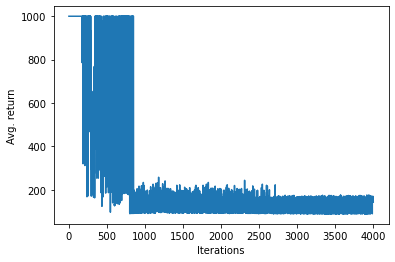

In [326]:
#With baseline
episode_length = []
curr_iter = 0
while(curr_iter<=4000):
    curr_iter += 1
    policy_params_temp = policy_params.copy()    
    episode_trace = runEpisode(policy_params,value_params, gamma)
    print("\n EPISODE LENGTH: ",len(episode_trace), "CURR ITER: ", curr_iter)
    episode_length.append(len(episode_trace))
#     for a_step in range(len(episode_trace)):
#         G = 0
#         for idx in range(a_step, len(episode_trace)):
#             G += episode_trace[idx][2]
        
#         state_t = episode_trace[a_step][0]
#         state_t_feature_vector = phi_s_cosine(state_t[0], state_t[1], True)

#         v_hat_s = np.dot(state_t_feature_vector, value_params)
#         delta = G - v_hat_s
        
#         value_params += valueFunction_step_size*delta*state_t_feature_vector
        

#         state_t_feature_policy_param_product = np.dot(policy_params.T, state_t_feature_vector)
        
        
#         exp_terms = np.exp(softmax_sigma*state_t_feature_policy_param_product)
#         pi_values = exp_terms/np.sum(exp_terms)
        
# #         print("Pi values: ",pi_values)
# #         print("G: ",G,". Delta: ",delta)
#         if episode_trace[a_step][1] == -1:
#             policy_params[:,0] += policy_step_size*delta*(1-pi_values[0])*state_t_feature_vector
#             policy_params[:,1] += policy_step_size*delta*(-pi_values[0])*state_t_feature_vector
#         else:
#             policy_params[:,0] += policy_step_size*delta*(-pi_values[1])*state_t_feature_vector
#             policy_params[:,1] += policy_step_size*delta*(1-pi_values[1])*state_t_feature_vector
    
    max_diff = np.max(np.abs(policy_params_temp - policy_params))
    print(policy_step_size,valueFunction_step_size," Max diff: ",max_diff)
#     if max_diff<policy_step_size*1e-1 or len(episode_trace)<110:# 0.001 works with 1e-6 policy_step
#         break
    print("Mean episode length: ", np.mean(episode_length[max(0, curr_iter-100): curr_iter+1]))
    if np.mean(episode_length[max(0, curr_iter-100): curr_iter+1]) <= 125.0:# or max_diff<policy_step_size*1e2:
        print("Solved.")
        break
        
plt.figure()
plt.plot(np.arange(len(episode_length)), episode_length)
plt.xlabel('Iterations')
plt.ylabel('Avg. return')
# plt.ylim([-100, 1000])
plt.savefig('graph_mountaincar_actor-critic_'+str(policy_step_size)+'_'+str(valueFunction_step_size))

graph_mountaincar_actor-critic_policy_param0.0001_AND_v_param3e-05


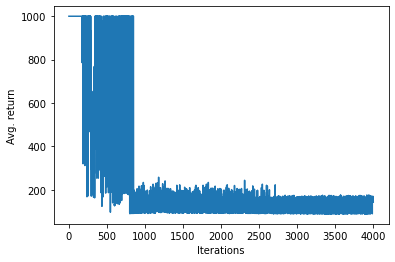

In [327]:
plt.figure()
plt.plot(np.arange(len(episode_length)), episode_length)
plt.xlabel('Iterations')
plt.ylabel('Avg. return')
# plt.ylim([-100, 1000])
print('graph_mountaincar_actor-critic_policy_param'+str(policy_step_size)+'_AND_v_param'+str(valueFunction_step_size))
plt.savefig('graph_mountaincar_actor-critic'+str(valueFunction_step_size))